# Model Training: Discriminative & Generative Models on SLAKE

This notebook provides an end-to-end pipeline for:

1. Loading and preprocessing the SLAKE dataset (English-only)
2. Training a CNN–LSTM discriminative baseline (answer classification)
3. Fine-tuning BLIP using LoRA (generative VQA)
4. Evaluating both models fairly using:
   - Overall / OPEN / CLOSED
   - CNN–LSTM: Accuracy, Top-5 Accuracy, Macro-F1
   - BLIP: Exact Match, Token-F1 (+ optional BLEU/ROUGE-L/BERTScore for OPEN)

---

**Key Hyperparameters** (inferred from 02_eda.ipynb):

- Max question length: 32
- Max question vocab size: 290
- Answer classes (Top-K): 220 + <unk>


## 1. Setup & Imports

In [ ]:
# Mount Google Drive if running in Google Colab
try:
    import os
    from pathlib import Path

    from google.colab import drive

    drive.mount("/content/drive")
    print("Session is running on Google Colab.")
    print(f"Current working directory: {Path.cwd()}")
    os.chdir(
        "/content/drive/MyDrive/insync/masters/courses/year2526_sem1/woa7015_advanced_machine_learning/alt_assessment/woa7015-medvqa"
    )
    print(f"Current working directory (After): {Path.cwd()}")

    if not Path("/content/data/SLAKE").exists():
        !uvx hf download BoKelvin/SLAKE --repo-type=dataset --local-dir /content/data/SLAKE/
        !unzip /content/data/SLAKE/imgs.zip -d /content/data/SLAKE/

    PROJECT_DIR = Path.cwd()
    DATASET_DIR = Path("/content/data/SLAKE/")

except ImportError:
    %load_ext autoreload
    %autoreload 2
    print("Session is not running on Google Colab.")
    print(f"Current working directory: {Path.cwd()}")

    PROJECT_DIR = Path.cwd().parent
    DATASET_DIR = PROJECT_DIR / "data" / "SLAKE"  # Or any other dataset path

assert DATASET_DIR.exists(), f"Dataset directory {DATASET_DIR} does not exist."
print(f"Dataset directory: {DATASET_DIR}")
!nvidia-smi

Mounted at /content/drive
Session is running on Google Colab.
Current working directory: /content
Current working directory (After): /content/drive/MyDrive/insync/masters/courses/year2526_sem1/woa7015_advanced_machine_learning/alt_assessment/woa7015-medvqa
Installed 18 packages in 26ms
Fetching 8 files: 100% 8/8 [00:03<00:00,  2.65it/s]
Download complete: : 217MB [00:03, 90.3MB/s]                             /content/data/SLAKE
Download complete: : 217MB [00:03, 71.1MB/s]
Archive:  /content/data/SLAKE/imgs.zip
   creating: /content/data/SLAKE/imgs/
  inflating: /content/data/SLAKE/__MACOSX/._imgs  
   creating: /content/data/SLAKE/imgs/xmlab29/
   creating: /content/data/SLAKE/imgs/xmlab198/
   creating: /content/data/SLAKE/imgs/xmlab508/
   creating: /content/data/SLAKE/imgs/xmlab395/
   creating: /content/data/SLAKE/imgs/xmlab16/
   creating: /content/data/SLAKE/imgs/xmlab537/
   creating: /content/data/SLAKE/imgs/xmlab361/
   creating: /content/data/SLAKE/imgs/xmlab153/
   creating:

In [2]:
# Weird bug on colab, we need to import this first before installing our package, even though transformers version is the same
from transformers import BlipProcessor

In [3]:
# Build and install the package
!uv build .
!uv pip install ./dist/woa7015_medvqa-0.1.0-py3-none-any.whl

Building source distribution (uv build backend)...
Successfully built dist/woa7015_medvqa-0.1.0.tar.gz
Successfully built dist/woa7015_medvqa-0.1.0-py3-none-any.whl
Using Python 3.12.12 environment at: /usr
Resolved 107 packages in 1.22s
Prepared 10 packages in 635ms
Uninstalled 6 packages in 138ms
Installed 10 packages in 39ms
 + bert-score==0.3.13
 + evaluate==0.4.6
 - matplotlib==3.10.0
 + matplotlib==3.10.8
 - nltk==3.9.1
 + nltk==3.9.2
 - numpy==2.0.2
 + numpy==2.4.1
 - pandas==2.2.2
 + pandas==2.3.3
 - peft==0.18.0
 + peft==0.18.1
 - rich==13.9.4
 + rich==14.2.0
 + rouge-score==0.1.2
 + woa7015-medvqa==0.1.0 (from file:///content/drive/MyDrive/insync/masters/courses/year2526_sem1/woa7015_advanced_machine_learning/alt_assessment/woa7015-medvqa/dist/woa7015_medvqa-0.1.0-py3-none-any.whl)


In [ ]:
import os
import time

import json
import random
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from woa7015_medvqa.v2.data.collate import collate_fn_blip, collate_fn_classify
from woa7015_medvqa.v2.data.slake import SLAKEDataset
from woa7015_medvqa.v2.data.tokenizers import (
    build_answer_vocab,
    build_question_vocab,
    make_answer_encoder,
    make_question_encoder,
)
from woa7015_medvqa.v2.data.transforms import image_transform
from woa7015_medvqa.v2.eval.evaluate_blip import evaluate_blip
from woa7015_medvqa.v2.eval.evaluate_cnn_lstm import evaluate_cnn_lstm
from woa7015_medvqa.v2.eval.metrics import (
    compute_classification_metrics,
    compute_text_metrics,
)
from woa7015_medvqa.v2.models.blip_lora import build_blip_with_lora
from woa7015_medvqa.v2.models.cnn_lstm import CNNLSTMClassifier
from woa7015_medvqa.v2.train.train_blip import BLIPTrainConfig, train_blip
from woa7015_medvqa.v2.train.train_cnn_lstm import CNNLSTMTrainConfig, train_cnn_lstm
from woa7015_medvqa.v2.utils import (
    count_params,
    load_checkpoint,
    plot_history,
    seed_everything,
)


## 2. Paths & Configurations

In [5]:
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# From EDA
MAX_Q_LEN = 32
MAX_Q_WORDS = 290
TOPK_ANS = 220

# Training hyperparameters
BATCH_SIZE_BASELINE = 128
BATCH_SIZE_BLIP = 64

NUM_WORKERS = 4

seed_everything(SEED)
print(f"Using device: {DEVICE}")

Using device: cuda


## 3. Build Question & Answer Tokenizers for CNN–LSTM

In [6]:
# Question vocab
q_vocab, q2id = build_question_vocab(
    str(DATASET_DIR / "train.json"),
    max_words=MAX_Q_WORDS,
    english_only=True,
)
encode_question = make_question_encoder(q2id, max_len=MAX_Q_LEN)

# Answer vocab
ans_vocab, ans2id, id2ans = build_answer_vocab(
    str(DATASET_DIR / "train.json"),
    topk=TOPK_ANS,
    english_only=True,
)
encode_answer = make_answer_encoder(ans2id)

print("Question vocab size (<pad> + <unk> + actual tokens):", len(q_vocab))
print("Answer vocab size (TopK + <unk>):", len(ans_vocab))

Question vocab size (<pad> + <unk> + actual tokens): 292
Answer vocab size (TopK + <unk>): 221


## 4. Build Datasets

In [7]:
# -----------------------------
# CNN–LSTM baseline datasets (tokenized)
# -----------------------------
train_ds_cls = SLAKEDataset(
    root_dir=DATASET_DIR,
    split="train",
    english_only=True,
    image_transform=image_transform,
    question_transform=encode_question,
    answer_transform=encode_answer,
)

val_ds_cls = SLAKEDataset(
    root_dir=DATASET_DIR,
    split="validation",
    english_only=True,
    image_transform=image_transform,
    question_transform=encode_question,
    answer_transform=encode_answer,
)

test_ds_cls = SLAKEDataset(
    root_dir=DATASET_DIR,
    split="test",
    english_only=True,
    image_transform=image_transform,
    question_transform=encode_question,
    answer_transform=encode_answer,
)

print("Classification datasets:")
print(
    "Train:", len(train_ds_cls), "| Val:", len(val_ds_cls), "| Test:", len(test_ds_cls)
)


# -----------------------------
# BLIP datasets (raw PIL + strings)
# -----------------------------
train_ds_blip = SLAKEDataset(
    root_dir=DATASET_DIR,
    split="train",
    english_only=True,
)

val_ds_blip = SLAKEDataset(
    root_dir=DATASET_DIR,
    split="validation",
    english_only=True,
)

test_ds_blip = SLAKEDataset(
    root_dir=DATASET_DIR,
    split="test",
    english_only=True,
)

print("BLIP datasets:")
print(
    "Train:",
    len(train_ds_blip),
    "| Val:",
    len(val_ds_blip),
    "| Test:",
    len(test_ds_blip),
)


Classification datasets:
Train: 4919 | Val: 1053 | Test: 1061
BLIP datasets:
Train: 4919 | Val: 1053 | Test: 1061


## 5. Model Definitions

In [8]:
cnn_lstm_frozen_backbone = CNNLSTMClassifier(
    num_answers=len(ans_vocab),
    question_vocab_size=len(q_vocab),
    freeze_cnn=True,
)

cnn_lstm_unfrozen_backbone = CNNLSTMClassifier(
    num_answers=len(ans_vocab),
    question_vocab_size=len(q_vocab),
    freeze_cnn=False,
)

processor, blip_lora = build_blip_with_lora(
    model_name="Salesforce/blip-vqa-base", r=8, alpha=32, dropout=0.05
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 230MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

trainable params: 2,064,384 || all params: 363,294,524 || trainable%: 0.5682


In [10]:
# Print model parameter counts
total, trainable = count_params(cnn_lstm_frozen_backbone)
print(
    f"CNN-LSTM Baseline (Frozen Backbone) - Total params: {total:,}, Trainable params: {trainable:,}"
)

total, trainable = count_params(cnn_lstm_unfrozen_backbone)
print(
    f"CNN-LSTM Baseline (Unfrozen Backbone) - Total params: {total:,}, Trainable params: {trainable:,}"
)

total, trainable = count_params(blip_lora)
print(f"BLIP with LoRA - Total params: {total:,}, Trainable params: {trainable:,}")

CNN-LSTM Baseline (Frozen Backbone) - Total params: 12,943,901, Trainable params: 1,767,389
CNN-LSTM Baseline (Unfrozen Backbone) - Total params: 12,943,901, Trainable params: 12,943,901
BLIP with LoRA - Total params: 363,294,524, Trainable params: 2,064,384


## 6. Training Utils

In [11]:
# CNN–LSTM dataloaders
train_loader_cls = DataLoader(
    train_ds_cls,
    batch_size=BATCH_SIZE_BASELINE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_classify,
)

val_loader_cls = DataLoader(
    val_ds_cls,
    batch_size=BATCH_SIZE_BASELINE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_classify,
)

test_loader_cls = DataLoader(
    test_ds_cls,
    batch_size=BATCH_SIZE_BASELINE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_classify,
)

# BLIP processor + dataloaders
train_loader_blip = DataLoader(
    train_ds_blip,
    batch_size=BATCH_SIZE_BLIP,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=partial(collate_fn_blip, processor=processor),
)

val_loader_blip = DataLoader(
    val_ds_blip,
    batch_size=BATCH_SIZE_BLIP,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=partial(collate_fn_blip, processor=processor),
)

test_loader_blip = DataLoader(
    test_ds_blip,
    batch_size=BATCH_SIZE_BLIP,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=partial(collate_fn_blip, processor=processor),
)

print("Loaders ready")

Loaders ready


In [12]:
CNNLSTM_UF_CKPT_DIR = PROJECT_DIR / "checkpoints/cnn_lstm_unfrozen"
CNNLSTM_F_CKPT_DIR = PROJECT_DIR / "checkpoints/cnn_lstm_frozen"
BLIP_CKPT_DIR = PROJECT_DIR / "checkpoints/blip_lora"

CNNLSTM_UF_BEST = CNNLSTM_UF_CKPT_DIR / "best.pt"
CNNLSTM_F_BEST = CNNLSTM_F_CKPT_DIR / "best.pt"
BLIP_BEST = BLIP_CKPT_DIR / "best.pt"

print("CNN-LSTM (Unfrozen Backbone) best exists:", CNNLSTM_UF_BEST.exists())
print("CNN-LSTM (Frozen Backbone) best exists:", CNNLSTM_F_BEST.exists())
print("BLIP best exists:", BLIP_BEST.exists())

CNN-LSTM (Unfrozen Backbone) best exists: True
CNN-LSTM (Frozen Backbone) best exists: True
BLIP best exists: True


## 7. Model Training

### 7.1. Train CNN–LSTM (Frozen Backbone)

In [13]:
train_cnnlstm_frozen = True  # switch off to skip training

start_time = time.time()
if train_cnnlstm_frozen:
    cfg = CNNLSTMTrainConfig(
        epochs=50,
        lr=1e-3,
        device=DEVICE,
        ckpt_dir=str(CNNLSTM_F_CKPT_DIR),
        best_metric="val_accuracy",
        maximize_metric=True,
    )

    cnnlstm_frozen_history = train_cnn_lstm(
        model=cnn_lstm_frozen_backbone,
        train_loader=train_loader_cls,
        val_loader=val_loader_cls,
        cfg=cfg,
        num_classes=len(ans_vocab),
    )

else:
    cnnlstm_frozen_history = None

end_time = time.time()
elapsed_seconds = end_time - start_time
elapsed_minutes = elapsed_seconds / 60

print(f"\nTotal execution time: {elapsed_minutes:.2f} minutes ({elapsed_seconds:.2f} seconds)")


Training CNN-LSTM (50 epochs)


Epoch 1/50: 100%|██████████| 39/39 [00:10<00:00,  3.58it/s, loss=1.8332]


Epoch 1 | TrainLoss=2.8775 TrainAcc=0.3472 | ValLoss=1.6766 ValAcc=0.5375
-> Best updated: val_accuracy=0.5375


Epoch 2/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=1.1113]


Epoch 2 | TrainLoss=1.3305 TrainAcc=0.6154 | ValLoss=1.0357 ValAcc=0.6591
-> Best updated: val_accuracy=0.6591


Epoch 3/50: 100%|██████████| 39/39 [00:10<00:00,  3.66it/s, loss=0.8058]


Epoch 3 | TrainLoss=0.9304 TrainAcc=0.6894 | ValLoss=0.8652 ValAcc=0.6923
-> Best updated: val_accuracy=0.6923


Epoch 4/50: 100%|██████████| 39/39 [00:10<00:00,  3.75it/s, loss=1.0115]


Epoch 4 | TrainLoss=0.7616 TrainAcc=0.7296 | ValLoss=0.7440 ValAcc=0.7341
-> Best updated: val_accuracy=0.7341


Epoch 5/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.5169]


Epoch 5 | TrainLoss=0.6508 TrainAcc=0.7693 | ValLoss=0.6907 ValAcc=0.7493
-> Best updated: val_accuracy=0.7493


Epoch 6/50: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.4421]


Epoch 6 | TrainLoss=0.5616 TrainAcc=0.8004 | ValLoss=0.6476 ValAcc=0.7702
-> Best updated: val_accuracy=0.7702


Epoch 7/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.6535]


Epoch 7 | TrainLoss=0.4930 TrainAcc=0.8242 | ValLoss=0.6168 ValAcc=0.7901
-> Best updated: val_accuracy=0.7901


Epoch 8/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.5858]


Epoch 8 | TrainLoss=0.4423 TrainAcc=0.8443 | ValLoss=0.6439 ValAcc=0.7768


Epoch 9/50: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.2565]


Epoch 9 | TrainLoss=0.4145 TrainAcc=0.8555 | ValLoss=0.6527 ValAcc=0.7825


Epoch 10/50: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.5445]


Epoch 10 | TrainLoss=0.3654 TrainAcc=0.8727 | ValLoss=0.6306 ValAcc=0.7844


Epoch 11/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.3329]


Epoch 11 | TrainLoss=0.3245 TrainAcc=0.8851 | ValLoss=0.6200 ValAcc=0.8110
-> Best updated: val_accuracy=0.8110


Epoch 12/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.3589]


Epoch 12 | TrainLoss=0.3079 TrainAcc=0.8971 | ValLoss=0.6391 ValAcc=0.7920


Epoch 13/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.2882]


Epoch 13 | TrainLoss=0.2596 TrainAcc=0.9103 | ValLoss=0.6634 ValAcc=0.7996


Epoch 14/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.2243]


Epoch 14 | TrainLoss=0.2246 TrainAcc=0.9295 | ValLoss=0.6404 ValAcc=0.8072


Epoch 15/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.2483]


Epoch 15 | TrainLoss=0.2052 TrainAcc=0.9341 | ValLoss=0.6423 ValAcc=0.8091


Epoch 16/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.2376]


Epoch 16 | TrainLoss=0.1770 TrainAcc=0.9461 | ValLoss=0.7234 ValAcc=0.7958


Epoch 17/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.1554]


Epoch 17 | TrainLoss=0.1523 TrainAcc=0.9541 | ValLoss=0.6980 ValAcc=0.8006


Epoch 18/50: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.2077]


Epoch 18 | TrainLoss=0.1662 TrainAcc=0.9449 | ValLoss=0.6881 ValAcc=0.8167
-> Best updated: val_accuracy=0.8167


Epoch 19/50: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0378]


Epoch 19 | TrainLoss=0.1271 TrainAcc=0.9612 | ValLoss=0.7122 ValAcc=0.8196
-> Best updated: val_accuracy=0.8196


Epoch 20/50: 100%|██████████| 39/39 [00:09<00:00,  3.93it/s, loss=0.0898]


Epoch 20 | TrainLoss=0.0953 TrainAcc=0.9744 | ValLoss=0.7178 ValAcc=0.8234
-> Best updated: val_accuracy=0.8234


Epoch 21/50: 100%|██████████| 39/39 [00:09<00:00,  3.92it/s, loss=0.0861]


Epoch 21 | TrainLoss=0.0773 TrainAcc=0.9805 | ValLoss=0.7693 ValAcc=0.8091


Epoch 22/50: 100%|██████████| 39/39 [00:09<00:00,  3.95it/s, loss=0.1060]


Epoch 22 | TrainLoss=0.0767 TrainAcc=0.9803 | ValLoss=0.7486 ValAcc=0.8205


Epoch 23/50: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.2568]


Epoch 23 | TrainLoss=0.0794 TrainAcc=0.9782 | ValLoss=0.7608 ValAcc=0.8167


Epoch 24/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0910]


Epoch 24 | TrainLoss=0.0648 TrainAcc=0.9845 | ValLoss=0.7773 ValAcc=0.8148


Epoch 25/50: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0437]


Epoch 25 | TrainLoss=0.0611 TrainAcc=0.9852 | ValLoss=0.7755 ValAcc=0.8158


Epoch 26/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0566]


Epoch 26 | TrainLoss=0.0427 TrainAcc=0.9923 | ValLoss=0.7746 ValAcc=0.8148


Epoch 27/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0429]


Epoch 27 | TrainLoss=0.0409 TrainAcc=0.9919 | ValLoss=0.8506 ValAcc=0.8053


Epoch 28/50: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.0331]


Epoch 28 | TrainLoss=0.0427 TrainAcc=0.9906 | ValLoss=0.8346 ValAcc=0.8082


Epoch 29/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0720]


Epoch 29 | TrainLoss=0.0496 TrainAcc=0.9886 | ValLoss=0.8373 ValAcc=0.8082


Epoch 30/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0292]


Epoch 30 | TrainLoss=0.0415 TrainAcc=0.9919 | ValLoss=0.8533 ValAcc=0.8101


Epoch 31/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0392]


Epoch 31 | TrainLoss=0.0351 TrainAcc=0.9941 | ValLoss=0.8725 ValAcc=0.8139


Epoch 32/50: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0338]


Epoch 32 | TrainLoss=0.0363 TrainAcc=0.9911 | ValLoss=0.8576 ValAcc=0.8158


Epoch 33/50: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0648]


Epoch 33 | TrainLoss=0.0341 TrainAcc=0.9913 | ValLoss=0.8385 ValAcc=0.8186


Epoch 34/50: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.0426]


Epoch 34 | TrainLoss=0.0435 TrainAcc=0.9876 | ValLoss=0.9339 ValAcc=0.8082


Epoch 35/50: 100%|██████████| 39/39 [00:09<00:00,  3.94it/s, loss=0.0797]


Epoch 35 | TrainLoss=0.0422 TrainAcc=0.9882 | ValLoss=0.8258 ValAcc=0.8139


Epoch 36/50: 100%|██████████| 39/39 [00:09<00:00,  3.90it/s, loss=0.0270]


Epoch 36 | TrainLoss=0.0274 TrainAcc=0.9941 | ValLoss=0.8645 ValAcc=0.8158


Epoch 37/50: 100%|██████████| 39/39 [00:09<00:00,  3.93it/s, loss=0.0513]


Epoch 37 | TrainLoss=0.0250 TrainAcc=0.9937 | ValLoss=0.8773 ValAcc=0.8139


Epoch 38/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0212]


Epoch 38 | TrainLoss=0.0231 TrainAcc=0.9955 | ValLoss=0.8827 ValAcc=0.8167


Epoch 39/50: 100%|██████████| 39/39 [00:09<00:00,  4.01it/s, loss=0.0097]


Epoch 39 | TrainLoss=0.0211 TrainAcc=0.9959 | ValLoss=0.9871 ValAcc=0.8110


Epoch 40/50: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0238]


Epoch 40 | TrainLoss=0.0212 TrainAcc=0.9957 | ValLoss=0.9363 ValAcc=0.8158


Epoch 41/50: 100%|██████████| 39/39 [00:09<00:00,  3.91it/s, loss=0.0431]


Epoch 41 | TrainLoss=0.0248 TrainAcc=0.9931 | ValLoss=0.9185 ValAcc=0.8139


Epoch 42/50: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0097]


Epoch 42 | TrainLoss=0.0250 TrainAcc=0.9941 | ValLoss=0.8676 ValAcc=0.8253
-> Best updated: val_accuracy=0.8253


Epoch 43/50: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.0082]


Epoch 43 | TrainLoss=0.0162 TrainAcc=0.9970 | ValLoss=0.8924 ValAcc=0.8205


Epoch 44/50: 100%|██████████| 39/39 [00:10<00:00,  3.77it/s, loss=0.0164]


Epoch 44 | TrainLoss=0.0127 TrainAcc=0.9980 | ValLoss=0.9438 ValAcc=0.8167


Epoch 45/50: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0066]


Epoch 45 | TrainLoss=0.0108 TrainAcc=0.9982 | ValLoss=0.9665 ValAcc=0.8120


Epoch 46/50: 100%|██████████| 39/39 [00:10<00:00,  3.88it/s, loss=0.0097]


Epoch 46 | TrainLoss=0.0115 TrainAcc=0.9982 | ValLoss=0.9250 ValAcc=0.8110


Epoch 47/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.0323]


Epoch 47 | TrainLoss=0.0182 TrainAcc=0.9959 | ValLoss=0.9392 ValAcc=0.8034


Epoch 48/50: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.0160]


Epoch 48 | TrainLoss=0.0214 TrainAcc=0.9951 | ValLoss=0.9352 ValAcc=0.8186


Epoch 49/50: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.0057]


Epoch 49 | TrainLoss=0.0230 TrainAcc=0.9941 | ValLoss=0.9289 ValAcc=0.8196


Epoch 50/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.0243]


Epoch 50 | TrainLoss=0.0200 TrainAcc=0.9947 | ValLoss=0.9550 ValAcc=0.8110
Done CNN-LSTM training!

Total execution time: 11.23 minutes (673.81 seconds)


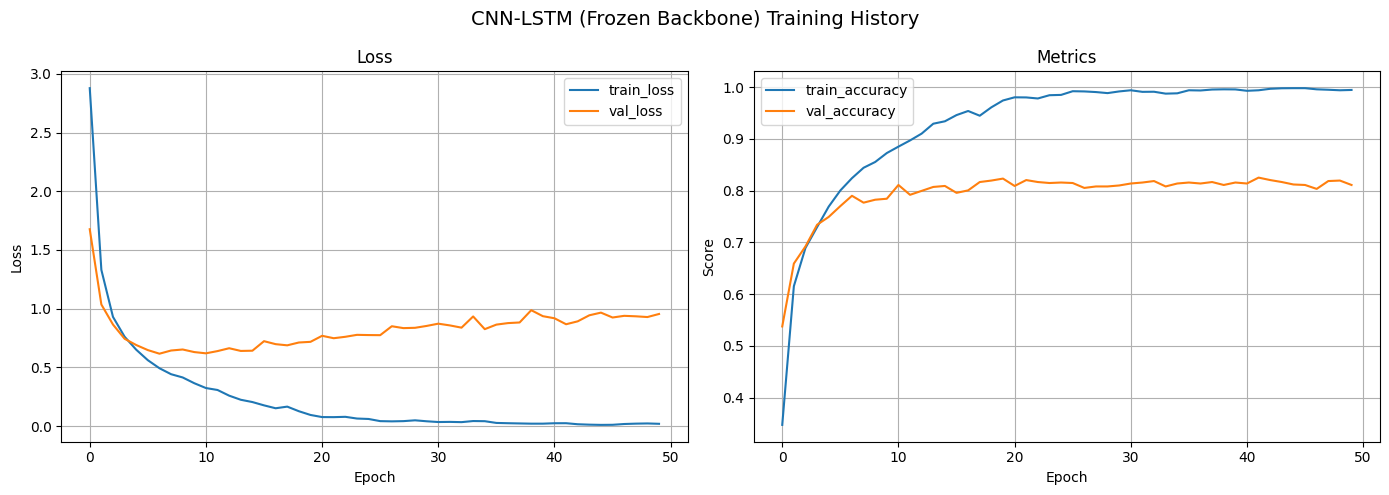

In [14]:
plot_history(cnnlstm_frozen_history, "CNN-LSTM (Frozen Backbone) Training History")

### 7.2. Train CNN–LSTM (Unfrozen Backbone)

In [15]:
train_cnnlstm_unfrozen = True  # switch off to skip training

start_time = time.time()
if train_cnnlstm_unfrozen:
    cfg = CNNLSTMTrainConfig(
        epochs=50,
        lr=1e-3,
        device=DEVICE,
        ckpt_dir=str(CNNLSTM_UF_CKPT_DIR),
        best_metric="val_accuracy",
        maximize_metric=True,
    )

    cnnlstm_unfrozen_history = train_cnn_lstm(
        model=cnn_lstm_unfrozen_backbone,
        train_loader=train_loader_cls,
        val_loader=val_loader_cls,
        cfg=cfg,
        num_classes=len(ans_vocab),
    )

else:
    cnnlstm_unfrozen_history = None

end_time = time.time()
elapsed_seconds = end_time - start_time
elapsed_minutes = elapsed_seconds / 60

print(f"\nTotal execution time: {elapsed_minutes:.2f} minutes ({elapsed_seconds:.2f} seconds)")

Training CNN-LSTM (50 epochs)


Epoch 1/50: 100%|██████████| 39/39 [00:10<00:00,  3.76it/s, loss=1.5140]


Epoch 1 | TrainLoss=2.7938 TrainAcc=0.3613 | ValLoss=1.6330 ValAcc=0.5470
-> Best updated: val_accuracy=0.5470


Epoch 2/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=1.1490]


Epoch 2 | TrainLoss=1.2784 TrainAcc=0.6272 | ValLoss=1.1173 ValAcc=0.6163
-> Best updated: val_accuracy=0.6163


Epoch 3/50: 100%|██████████| 39/39 [00:10<00:00,  3.77it/s, loss=0.8802]


Epoch 3 | TrainLoss=0.8993 TrainAcc=0.6934 | ValLoss=0.9078 ValAcc=0.6781
-> Best updated: val_accuracy=0.6781


Epoch 4/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.6797]


Epoch 4 | TrainLoss=0.7404 TrainAcc=0.7378 | ValLoss=0.7091 ValAcc=0.7531
-> Best updated: val_accuracy=0.7531


Epoch 5/50: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.4582]


Epoch 5 | TrainLoss=0.6346 TrainAcc=0.7760 | ValLoss=0.6843 ValAcc=0.7635
-> Best updated: val_accuracy=0.7635


Epoch 6/50: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.6213]


Epoch 6 | TrainLoss=0.5699 TrainAcc=0.8022 | ValLoss=0.6392 ValAcc=0.7778
-> Best updated: val_accuracy=0.7778


Epoch 7/50: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.5437]


Epoch 7 | TrainLoss=0.5228 TrainAcc=0.8132 | ValLoss=0.7093 ValAcc=0.7578


Epoch 8/50: 100%|██████████| 39/39 [00:10<00:00,  3.75it/s, loss=0.5165]


Epoch 8 | TrainLoss=0.4926 TrainAcc=0.8221 | ValLoss=0.6803 ValAcc=0.7749


Epoch 9/50: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.6718]


Epoch 9 | TrainLoss=0.4645 TrainAcc=0.8323 | ValLoss=0.6210 ValAcc=0.7778


Epoch 10/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.5630]


Epoch 10 | TrainLoss=0.4480 TrainAcc=0.8382 | ValLoss=0.6007 ValAcc=0.7863
-> Best updated: val_accuracy=0.7863


Epoch 11/50: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.4122]


Epoch 11 | TrainLoss=0.4149 TrainAcc=0.8447 | ValLoss=0.5850 ValAcc=0.7977
-> Best updated: val_accuracy=0.7977


Epoch 12/50: 100%|██████████| 39/39 [00:10<00:00,  3.72it/s, loss=0.4343]


Epoch 12 | TrainLoss=0.3924 TrainAcc=0.8593 | ValLoss=0.5951 ValAcc=0.8063
-> Best updated: val_accuracy=0.8063


Epoch 13/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.6611]


Epoch 13 | TrainLoss=0.3726 TrainAcc=0.8607 | ValLoss=0.5880 ValAcc=0.8015


Epoch 14/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.2495]


Epoch 14 | TrainLoss=0.3613 TrainAcc=0.8721 | ValLoss=0.6144 ValAcc=0.8186
-> Best updated: val_accuracy=0.8186


Epoch 15/50: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s, loss=0.2705]


Epoch 15 | TrainLoss=0.3364 TrainAcc=0.8815 | ValLoss=0.5928 ValAcc=0.8101


Epoch 16/50: 100%|██████████| 39/39 [00:10<00:00,  3.75it/s, loss=0.2889]


Epoch 16 | TrainLoss=0.3222 TrainAcc=0.8845 | ValLoss=0.6177 ValAcc=0.8158


Epoch 17/50: 100%|██████████| 39/39 [00:10<00:00,  3.76it/s, loss=0.3918]


Epoch 17 | TrainLoss=0.3077 TrainAcc=0.8878 | ValLoss=0.6414 ValAcc=0.8053


Epoch 18/50: 100%|██████████| 39/39 [00:10<00:00,  3.76it/s, loss=0.1902]


Epoch 18 | TrainLoss=0.2945 TrainAcc=0.8916 | ValLoss=1.3106 ValAcc=0.6401


Epoch 19/50: 100%|██████████| 39/39 [00:10<00:00,  3.76it/s, loss=0.4203]


Epoch 19 | TrainLoss=0.2851 TrainAcc=0.8996 | ValLoss=0.6804 ValAcc=0.8015


Epoch 20/50: 100%|██████████| 39/39 [00:10<00:00,  3.74it/s, loss=0.1660]


Epoch 20 | TrainLoss=0.2812 TrainAcc=0.8977 | ValLoss=0.6560 ValAcc=0.7977


Epoch 21/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.1453]


Epoch 21 | TrainLoss=0.2620 TrainAcc=0.9053 | ValLoss=0.7163 ValAcc=0.8072


Epoch 22/50: 100%|██████████| 39/39 [00:10<00:00,  3.71it/s, loss=0.1697]


Epoch 22 | TrainLoss=0.2580 TrainAcc=0.9083 | ValLoss=0.6702 ValAcc=0.8101


Epoch 23/50: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.2802]


Epoch 23 | TrainLoss=0.2392 TrainAcc=0.9132 | ValLoss=0.7000 ValAcc=0.8129


Epoch 24/50: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.5387]


Epoch 24 | TrainLoss=0.2205 TrainAcc=0.9225 | ValLoss=0.6897 ValAcc=0.8129


Epoch 25/50: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, loss=0.3379]


Epoch 25 | TrainLoss=0.2185 TrainAcc=0.9225 | ValLoss=0.6983 ValAcc=0.8196
-> Best updated: val_accuracy=0.8196


Epoch 26/50: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.1549]


Epoch 26 | TrainLoss=0.2004 TrainAcc=0.9264 | ValLoss=0.7153 ValAcc=0.8224
-> Best updated: val_accuracy=0.8224


Epoch 27/50: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s, loss=0.1648]


Epoch 27 | TrainLoss=0.1916 TrainAcc=0.9329 | ValLoss=0.7271 ValAcc=0.8034


Epoch 28/50: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.2224]


Epoch 28 | TrainLoss=0.1773 TrainAcc=0.9370 | ValLoss=0.7447 ValAcc=0.8205


Epoch 29/50: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s, loss=0.2080]


Epoch 29 | TrainLoss=0.1675 TrainAcc=0.9419 | ValLoss=0.7921 ValAcc=0.8139


Epoch 30/50: 100%|██████████| 39/39 [00:10<00:00,  3.77it/s, loss=0.0785]


Epoch 30 | TrainLoss=0.1663 TrainAcc=0.9427 | ValLoss=0.7562 ValAcc=0.8196


Epoch 31/50: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.2580]


Epoch 31 | TrainLoss=0.1605 TrainAcc=0.9412 | ValLoss=0.7925 ValAcc=0.8101


Epoch 32/50: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s, loss=0.1265]


Epoch 32 | TrainLoss=0.1514 TrainAcc=0.9469 | ValLoss=0.7898 ValAcc=0.8186


Epoch 33/50: 100%|██████████| 39/39 [00:10<00:00,  3.65it/s, loss=0.2270]


Epoch 33 | TrainLoss=0.1414 TrainAcc=0.9494 | ValLoss=0.8127 ValAcc=0.8177


Epoch 34/50: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.2847]


Epoch 34 | TrainLoss=0.1284 TrainAcc=0.9573 | ValLoss=0.8285 ValAcc=0.8082


Epoch 35/50: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s, loss=0.1122]


Epoch 35 | TrainLoss=0.1258 TrainAcc=0.9583 | ValLoss=0.8400 ValAcc=0.8186


Epoch 36/50: 100%|██████████| 39/39 [00:10<00:00,  3.74it/s, loss=0.0529]


Epoch 36 | TrainLoss=0.1056 TrainAcc=0.9640 | ValLoss=0.8216 ValAcc=0.8120


Epoch 37/50: 100%|██████████| 39/39 [00:10<00:00,  3.89it/s, loss=0.0757]


Epoch 37 | TrainLoss=0.0971 TrainAcc=0.9656 | ValLoss=0.8355 ValAcc=0.8063


Epoch 38/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.0367]


Epoch 38 | TrainLoss=0.1026 TrainAcc=0.9656 | ValLoss=0.8814 ValAcc=0.8167


Epoch 39/50: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s, loss=0.1114]


Epoch 39 | TrainLoss=0.0984 TrainAcc=0.9661 | ValLoss=0.8936 ValAcc=0.8167


Epoch 40/50: 100%|██████████| 39/39 [00:10<00:00,  3.90it/s, loss=0.1551]


Epoch 40 | TrainLoss=0.0867 TrainAcc=0.9717 | ValLoss=0.8750 ValAcc=0.8129


Epoch 41/50: 100%|██████████| 39/39 [00:10<00:00,  3.80it/s, loss=0.0558]


Epoch 41 | TrainLoss=0.0817 TrainAcc=0.9746 | ValLoss=0.8932 ValAcc=0.8148


Epoch 42/50: 100%|██████████| 39/39 [00:10<00:00,  3.72it/s, loss=0.0548]


Epoch 42 | TrainLoss=0.0798 TrainAcc=0.9744 | ValLoss=0.9451 ValAcc=0.8120


Epoch 43/50: 100%|██████████| 39/39 [00:10<00:00,  3.75it/s, loss=0.0207]


Epoch 43 | TrainLoss=0.0691 TrainAcc=0.9795 | ValLoss=0.9102 ValAcc=0.8186


Epoch 44/50: 100%|██████████| 39/39 [00:10<00:00,  3.72it/s, loss=0.1413]


Epoch 44 | TrainLoss=0.0653 TrainAcc=0.9785 | ValLoss=0.9371 ValAcc=0.8158


Epoch 45/50: 100%|██████████| 39/39 [00:10<00:00,  3.77it/s, loss=0.0482]


Epoch 45 | TrainLoss=0.0680 TrainAcc=0.9776 | ValLoss=0.9532 ValAcc=0.8110


Epoch 46/50: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s, loss=0.1299]


Epoch 46 | TrainLoss=0.0588 TrainAcc=0.9825 | ValLoss=0.9746 ValAcc=0.8177


Epoch 47/50: 100%|██████████| 39/39 [00:10<00:00,  3.74it/s, loss=0.0572]


Epoch 47 | TrainLoss=0.0476 TrainAcc=0.9886 | ValLoss=0.9714 ValAcc=0.8196


Epoch 48/50: 100%|██████████| 39/39 [00:10<00:00,  3.69it/s, loss=0.0534]


Epoch 48 | TrainLoss=0.0457 TrainAcc=0.9876 | ValLoss=1.0099 ValAcc=0.8082


Epoch 49/50: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s, loss=0.0156]


Epoch 49 | TrainLoss=0.0449 TrainAcc=0.9878 | ValLoss=0.9835 ValAcc=0.8205


Epoch 50/50: 100%|██████████| 39/39 [00:10<00:00,  3.74it/s, loss=0.0145]


Epoch 50 | TrainLoss=0.0405 TrainAcc=0.9884 | ValLoss=1.0429 ValAcc=0.8148
Done CNN-LSTM training!

Total execution time: 12.16 minutes (729.54 seconds)


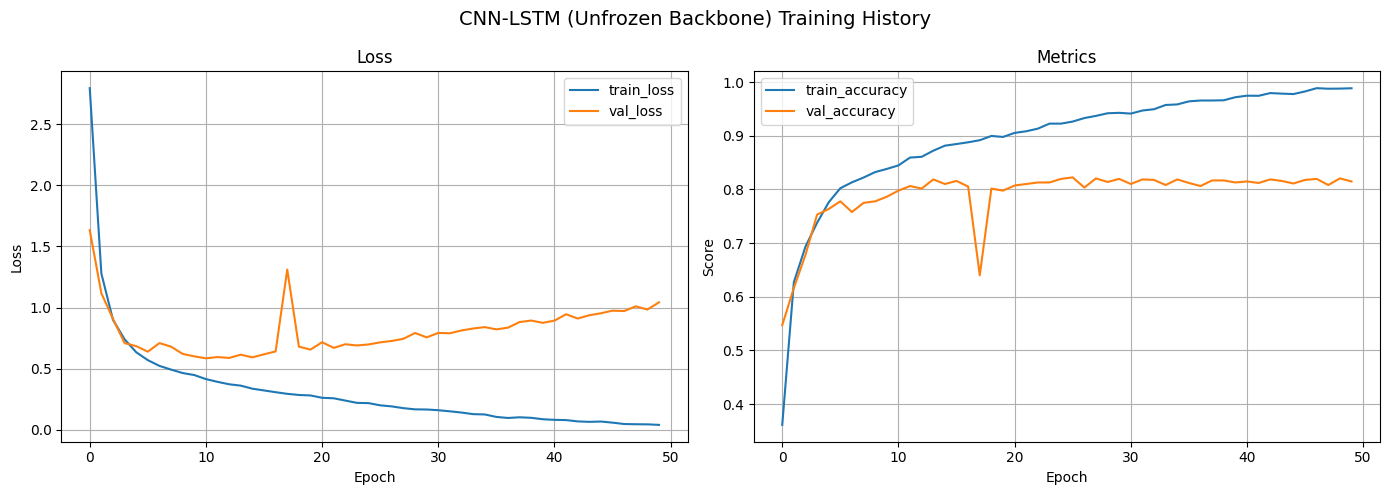

In [16]:
plot_history(cnnlstm_unfrozen_history, "CNN-LSTM (Unfrozen Backbone) Training History")

### 7.3. Train BLIP with LoRA

In [17]:
train_blip_flag = True  # switch off to skip training

start_time = time.time()
if train_blip_flag:
    cfg_blip = BLIPTrainConfig(
        epochs=20,
        lr=1e-4,
        device=DEVICE,
        ckpt_dir=str(BLIP_CKPT_DIR),
        best_metric="val_token_f1",
        maximize_metric=True,
        max_new_tokens=20,
    )

    blip_history = train_blip(
        model=blip_lora,
        processor=processor,
        train_loader=train_loader_blip,
        val_loader=val_loader_blip,
        cfg=cfg_blip,
    )
else:
    blip_history = None

end_time = time.time()
elapsed_seconds = end_time - start_time
elapsed_minutes = elapsed_seconds / 60

print(f"\nTotal execution time: {elapsed_minutes:.2f} minutes ({elapsed_seconds:.2f} seconds)")


Training BLIP+LoRA (20 epochs)


Evaluating: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 1 | TrainLoss=8.6413 | ValLoss=7.8889 | ValEM=0.4501 ValTokenF1=0.4968
-> Best updated: val_token_f1=0.4968


Evaluating: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 2 | TrainLoss=8.1289 | ValLoss=7.2432 | ValEM=0.5119 ValTokenF1=0.5601
-> Best updated: val_token_f1=0.5601


Evaluating: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 3 | TrainLoss=7.4196 | ValLoss=6.8210 | ValEM=0.5850 ValTokenF1=0.6316
-> Best updated: val_token_f1=0.6316


Evaluating: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 4 | TrainLoss=7.2396 | ValLoss=6.7020 | ValEM=0.5878 ValTokenF1=0.6344
-> Best updated: val_token_f1=0.6344


Evaluating: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


Epoch 5 | TrainLoss=7.0615 | ValLoss=6.6364 | ValEM=0.6296 ValTokenF1=0.6806
-> Best updated: val_token_f1=0.6806


Evaluating: 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


Epoch 6 | TrainLoss=7.0113 | ValLoss=6.5893 | ValEM=0.6448 ValTokenF1=0.6980
-> Best updated: val_token_f1=0.6980


Evaluating: 100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


Epoch 7 | TrainLoss=6.9969 | ValLoss=6.5554 | ValEM=0.6629 ValTokenF1=0.7118
-> Best updated: val_token_f1=0.7118


Evaluating: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch 8 | TrainLoss=7.0214 | ValLoss=6.5427 | ValEM=0.6610 ValTokenF1=0.7145
-> Best updated: val_token_f1=0.7145


Evaluating: 100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


Epoch 9 | TrainLoss=6.9367 | ValLoss=6.5183 | ValEM=0.6857 ValTokenF1=0.7450
-> Best updated: val_token_f1=0.7450


Evaluating: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Epoch 10 | TrainLoss=6.8866 | ValLoss=6.4984 | ValEM=0.6961 ValTokenF1=0.7504
-> Best updated: val_token_f1=0.7504


Evaluating: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s]


Epoch 11 | TrainLoss=6.9570 | ValLoss=6.4846 | ValEM=0.6866 ValTokenF1=0.7359


Evaluating: 100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


Epoch 12 | TrainLoss=6.9272 | ValLoss=6.4736 | ValEM=0.6933 ValTokenF1=0.7472


Evaluating: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Epoch 13 | TrainLoss=6.9263 | ValLoss=6.4646 | ValEM=0.7028 ValTokenF1=0.7624
-> Best updated: val_token_f1=0.7624


Evaluating: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


Epoch 14 | TrainLoss=6.8975 | ValLoss=6.4562 | ValEM=0.6952 ValTokenF1=0.7506


Evaluating: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]


Epoch 15 | TrainLoss=6.8413 | ValLoss=6.4637 | ValEM=0.6942 ValTokenF1=0.7460


Evaluating: 100%|██████████| 17/17 [00:14<00:00,  1.13it/s]


Epoch 16 | TrainLoss=6.7734 | ValLoss=6.4462 | ValEM=0.7123 ValTokenF1=0.7562


Evaluating: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 17 | TrainLoss=6.9598 | ValLoss=6.4281 | ValEM=0.7189 ValTokenF1=0.7711
-> Best updated: val_token_f1=0.7711


Evaluating: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Epoch 18 | TrainLoss=6.9014 | ValLoss=6.4268 | ValEM=0.7104 ValTokenF1=0.7635


Evaluating: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


Epoch 19 | TrainLoss=6.9049 | ValLoss=6.4230 | ValEM=0.7227 ValTokenF1=0.7732
-> Best updated: val_token_f1=0.7732


Evaluating: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Epoch 20 | TrainLoss=6.8319 | ValLoss=6.4212 | ValEM=0.7198 ValTokenF1=0.7671
Done BLIP+LoRA training!

Total execution time: 51.43 minutes (3085.60 seconds)


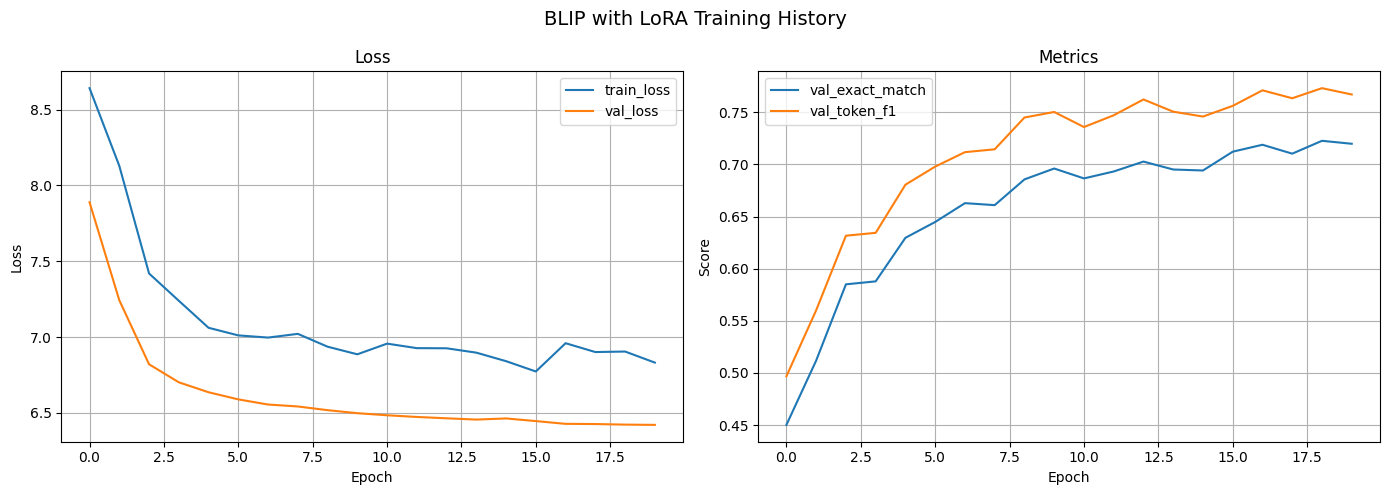

In [18]:
plot_history(blip_history, "BLIP with LoRA Training History")

In [ ]:
# Sava blip_history, cnnlstm_frozen_history, cnnlstm_unfrozen_history to json file
with open(PROJECT_DIR / "checkpoints/blip_lora/history.json", "w") as f:
    json.dump(blip_history, f)
    print("Saved blip_history to json file")

with open(PROJECT_DIR / "checkpoints/cnn_lstm_frozen/history.json", "w") as f:
    json.dump(cnnlstm_frozen_history, f)
    print("Saved cnnlstm_frozen_history to json file")

with open(PROJECT_DIR / "checkpoints/cnn_lstm_unfrozen/history.json", "w") as f:
    json.dump(cnnlstm_unfrozen_history, f)
    print("Saved cnnlstm_unfrozen_history to json file")

Saved blip_history to json file
Saved cnnlstm_frozen_history to json file
Saved cnnlstm_unfrozen_history to json file


## 8. Evaluate Models

In [20]:
if CNNLSTM_F_BEST.exists():
    load_checkpoint(cnn_lstm_frozen_backbone, str(CNNLSTM_F_BEST), device=DEVICE)
    print("Loaded CNN-LSTM frozen best checkpoint")

if CNNLSTM_UF_BEST.exists():
    load_checkpoint(cnn_lstm_unfrozen_backbone, str(CNNLSTM_UF_BEST), device=DEVICE)
    print("Loaded CNN-LSTM unfrozen best checkpoint")

if BLIP_BEST.exists():
    load_checkpoint(blip_lora, str(BLIP_BEST), device=DEVICE)
    print("Loaded BLIP with LoRA best checkpoint")

Loaded CNN-LSTM frozen best checkpoint
Loaded CNN-LSTM unfrozen best checkpoint
Loaded BLIP with LoRA best checkpoint


### 8.1. Evaluate CNN–LSTM (Frozen Backbone)

In [21]:
cnnlstm_frozen_test_results = evaluate_cnn_lstm(
    model=cnn_lstm_frozen_backbone,
    loader=test_loader_cls,
    device=DEVICE,
    num_classes=len(ans_vocab),
)

cnnlstm_frozen_test_results

Evaluating CNN-LSTM: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

CNN-LSTM Test Evaluation Results:
[OVERALL]
  accuracy: 0.7983
  macro_f1: 0.4758
  top5_accuracy: 0.9576
  loss: 0.9709
[OPEN]
  accuracy: 0.7767
  macro_f1: 0.4718
  top5_accuracy: 0.9318
[CLOSED]
  accuracy: 0.8317
  macro_f1: 0.6095
  top5_accuracy: 0.9976


{'overall': {'accuracy': 0.7983034872761545,
  'macro_f1': 0.4758365935229792,
  'top5_accuracy': 0.9575871819038643,
  'loss': 0.9709336928440421},
 'open': {'accuracy': 0.7767441860465116,
  'macro_f1': 0.4717856622597686,
  'top5_accuracy': 0.931782945736434},
 'closed': {'accuracy': 0.8317307692307693,
  'macro_f1': 0.6095090089790796,
  'top5_accuracy': 0.9975961538461539}}

### 8.2. Evaluate CNN–LSTM (Unfrozen Backbone)

In [22]:
cnnlstm_unfrozen_test_results = evaluate_cnn_lstm(
    model=cnn_lstm_unfrozen_backbone,
    loader=test_loader_cls,
    device=DEVICE,
    num_classes=len(ans_vocab),
)

cnnlstm_unfrozen_test_results

Evaluating CNN-LSTM: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

CNN-LSTM Test Evaluation Results:
[OVERALL]
  accuracy: 0.7766
  macro_f1: 0.4350
  top5_accuracy: 0.9576
  loss: 0.8657
[OPEN]
  accuracy: 0.7473
  macro_f1: 0.4238
  top5_accuracy: 0.9318
[CLOSED]
  accuracy: 0.8221
  macro_f1: 0.6600
  top5_accuracy: 0.9976


{'overall': {'accuracy': 0.7766258246936852,
  'macro_f1': 0.4349948134894027,
  'top5_accuracy': 0.9575871819038643,
  'loss': 0.865717133410577},
 'open': {'accuracy': 0.7472868217054264,
  'macro_f1': 0.4238194689621836,
  'top5_accuracy': 0.931782945736434},
 'closed': {'accuracy': 0.8221153846153846,
  'macro_f1': 0.6600430343465338,
  'top5_accuracy': 0.9975961538461539}}

### 8.3. Evaluate BLIP with LoRA

In [ ]:
blip_test_results = evaluate_blip(
    model=blip_lora,
    processor=processor,
    loader=test_loader_blip,
    device=DEVICE,
    max_new_tokens=20,
)

blip_test_results

Evaluating BLIP: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


Computing Overall Metrics...
Computing OPEN Metrics...
  - Found 645 OPEN questions. Running BERTScore...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Computing CLOSED Metrics...

BLIP Test Evaluation Results:
[OVERALL]
  exact_match: 0.6927
  token_f1: 0.7364
[OPEN]
  exact_match: 0.6202
  token_f1: 0.6919
  bleu: 0.0311
  rougeL: 0.7259
  bertscore_precision: 0.9194
  bertscore_recall: 0.9136
  bertscore_f1: 0.9162
[CLOSED]
  exact_match: 0.8053
  token_f1: 0.8053


{'overall': {'exact_match': 0.6927426955702167,
  'token_f1': 0.7363728224736152},
 'open': {'exact_match': 0.6201550387596899,
  'token_f1': 0.6919249064255903,
  'bleu': 0.0311152956292054,
  'rougeL': 0.7259313377507632,
  'bertscore_precision': 0.9193637511526891,
  'bertscore_recall': 0.9136347408442534,
  'bertscore_f1': 0.9162245675574902},
 'closed': {'exact_match': 0.8052884615384616, 'token_f1': 0.8052884615384616}}

In [24]:
# Save test_results into json file
with open(PROJECT_DIR / "checkpoints/blip_lora/test_results.json", "w") as f:
    json.dump(blip_test_results, f)
    print("Saved blip_test_results to json file")

with open(PROJECT_DIR / "checkpoints/cnn_lstm_frozen/test_results.json", "w") as f:
    json.dump(cnnlstm_frozen_test_results, f)
    print("Saved cnnlstm_frozen_test_results to json file")

with open(
    PROJECT_DIR / "checkpoints/cnn_lstm_unfrozen/test_results.json", "w"
) as f:
    json.dump(cnnlstm_unfrozen_test_results, f)
    print("Saved cnnlstm_unfrozen_test_results to json file")

Saved blip_test_results to json file
Saved cnnlstm_frozen_test_results to json file
Saved cnnlstm_unfrozen_test_results to json file
